In [1]:
import sys

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

sys.path.append("../")

In [2]:
ls ../tools/in

0000.txt  0013.txt  0026.txt  0039.txt  0052.txt  0065.txt  0078.txt  0091.txt
0001.txt  0014.txt  0027.txt  0040.txt  0053.txt  0066.txt  0079.txt  0092.txt
0002.txt  0015.txt  0028.txt  0041.txt  0054.txt  0067.txt  0080.txt  0093.txt
0003.txt  0016.txt  0029.txt  0042.txt  0055.txt  0068.txt  0081.txt  0094.txt
0004.txt  0017.txt  0030.txt  0043.txt  0056.txt  0069.txt  0082.txt  0095.txt
0005.txt  0018.txt  0031.txt  0044.txt  0057.txt  0070.txt  0083.txt  0096.txt
0006.txt  0019.txt  0032.txt  0045.txt  0058.txt  0071.txt  0084.txt  0097.txt
0007.txt  0020.txt  0033.txt  0046.txt  0059.txt  0072.txt  0085.txt  0098.txt
0008.txt  0021.txt  0034.txt  0047.txt  0060.txt  0073.txt  0086.txt  0099.txt
0009.txt  0022.txt  0035.txt  0048.txt  0061.txt  0074.txt  0087.txt
0010.txt  0023.txt  0036.txt  0049.txt  0062.txt  0075.txt  0088.txt
0011.txt  0024.txt  0037.txt  0050.txt  0063.txt  0076.txt  0089.txt
0012.txt  0025.txt  0038.txt  0051.txt  0064.txt  0077.txt  0090.txt


In [3]:
filename = "../tools/in/0006.txt"
with open(filename) as f:
    N, K, W, C = map(int, f.readline().split())
    true_bedrock = np.array([list(map(int, f.readline().split())) for _ in range(N)], dtype=np.int32)
    water_sources = []
    for _ in range(W):
        y, x = map(int, f.readline().split())
        water_sources.append([y, x])
    houses = []
    for _ in range(K):
        y, x = map(int, f.readline().split())
        houses.append([y, x])

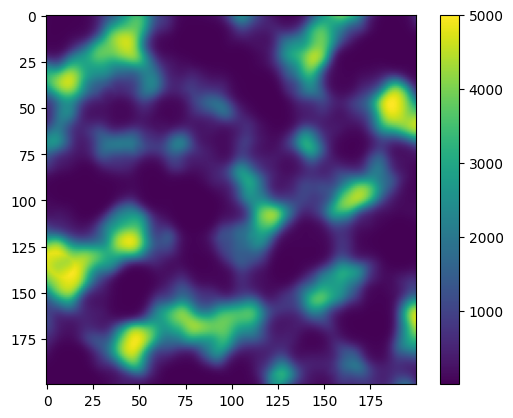

In [4]:
plt.imshow(true_bedrock)
plt.colorbar()

In [5]:
class GaussianProcess:
    # TODO: 修正コレスキー分解
    def __init__(self, X, y, n_max_data, sq_sigma_noise, sq_sigma_rbf):
        """
        Args:
            X: [n_data, 2]
            y: [n_data]
            n_max_data (int):
            sq_sigma_noise (float):
            sq_sigma_rbf (float):
        """
        assert len(X) == len(y)
        n_data = len(X)
        assert n_data <= n_max_data
        assert X.shape[1] == 2
        self.gamma = 0.5 / sq_sigma_rbf ** 2
        self.K = np.empty((n_max_data, n_max_data))
        K = self.kernel_func(X, X)
        K.flat[::n_data + 1] += sq_sigma_noise
        self.K[:n_data, :n_data] = K
        self.K_inv = np.empty((n_max_data, n_max_data))
        self.K_inv[:n_data, :n_data] = np.linalg.inv(self.K[:n_data, :n_data])
        self.sq_sigma_noise = sq_sigma_noise
        self.n_data = n_data
        self.X = np.empty((n_max_data, 2), dtype=np.int32)
        self.X[:n_data] = X
        self.y = np.empty(n_max_data)
        self.y[:n_data] = y

    def add_data(self, x, y):
        """
        Args:
            x: [2]
            y (float):
        """
        self.X[self.n_data] = x
        self.y[self.n_data] = y
        k = self.kernel_func(x.reshape(1, 2), self.X[:self.n_data]).reshape(-1)
        self.K[self.n_data, :self.n_data] = k
        self.K[:self.n_data, self.n_data] = k
        self.K[self.n_data, self.n_data] = d = self.kernel_func(x.reshape(1, 2)).reshape(tuple()) + self.sq_sigma_noise
        v = self.K_inv[:self.n_data, :self.n_data] @ k
        t = 1.0 / (d - np.dot(k, v))
        tv = t * v
        self.K_inv[:self.n_data, :self.n_data] += tv[:, None] * v[None, :]
        self.K_inv[self.n_data, :self.n_data] = -tv
        self.K_inv[:self.n_data, self.n_data] = -tv
        self.K_inv[self.n_data, self.n_data] = t
        self.n_data += 1

    def kernel_func(self, A, B=None):
        """
        Args:
            A (np.ndarray): [n_data_a, 2]
            B: [n_data_b, 2]
        """
        if B is None:
            return np.ones(len(A))
        assert A.shape[1] == B.shape[1] == 2
        D = A[:, None, :] - B[None, :, :]
        K = np.hypot(D[:, :, 0], D[:, :, 1])
        K = np.exp(-self.gamma * K)
        return K
    
    def predict(self, X, mu, sq_sigma):
        """
        Args:
            X: [n_data_pred, 2]
            mu (float):
            sq_sigma (float):
        """
        assert X.shape[1] == 2
        # [n_data_pred, n_data]  O(n_data_pred * n_data)
        k_star_T = self.kernel_func(X, self.X[:self.n_data])
        # [n_data_pred, n_data]  O(n_data_pred * n_data * n_data)
        k_star_T_K_inv = k_star_T @ self.K_inv[:self.n_data, :self.n_data]
        # [n_data_pred]
        mean = k_star_T_K_inv @ (self.y[:self.n_data] - mu) + mu
        # [n_data_pred]
        k_star_star = self.kernel_func(X)
        # [n_data_pred]
        var = (k_star_star - (k_star_T_K_inv * k_star_T).sum(1)) * sq_sigma
        return mean, var

In [6]:
X = np.random.randint(0, N, (400, 2))
X_pred = np.array([[y, x] for y in range(N) for x in range(N)])

y = true_bedrock[X[:, 0], X[:, 1]]
mu = 2505.0
sq_sigma = 1000.0 ** 2
sq_sigma_noise = (10.0 / mu) ** 2
sq_sigma_rbf = 10.0
gp = GaussianProcess(X, y, len(X), sq_sigma_noise, sq_sigma_rbf)
mean, var = gp.predict(X_pred, mu, sq_sigma)
mean = mean.reshape(N, N)
var = var.reshape(N, N)

gp2 = GaussianProcess(np.zeros((0, 2)), np.zeros(0), len(X), sq_sigma_noise, sq_sigma_rbf)
for x, yi in zip(X, y):
    gp2.add_data(x, yi)
mean2, var2 = gp2.predict(X_pred, mu, sq_sigma)
mean2 = mean2.reshape(N, N)
var2 = var2.reshape(N, N)


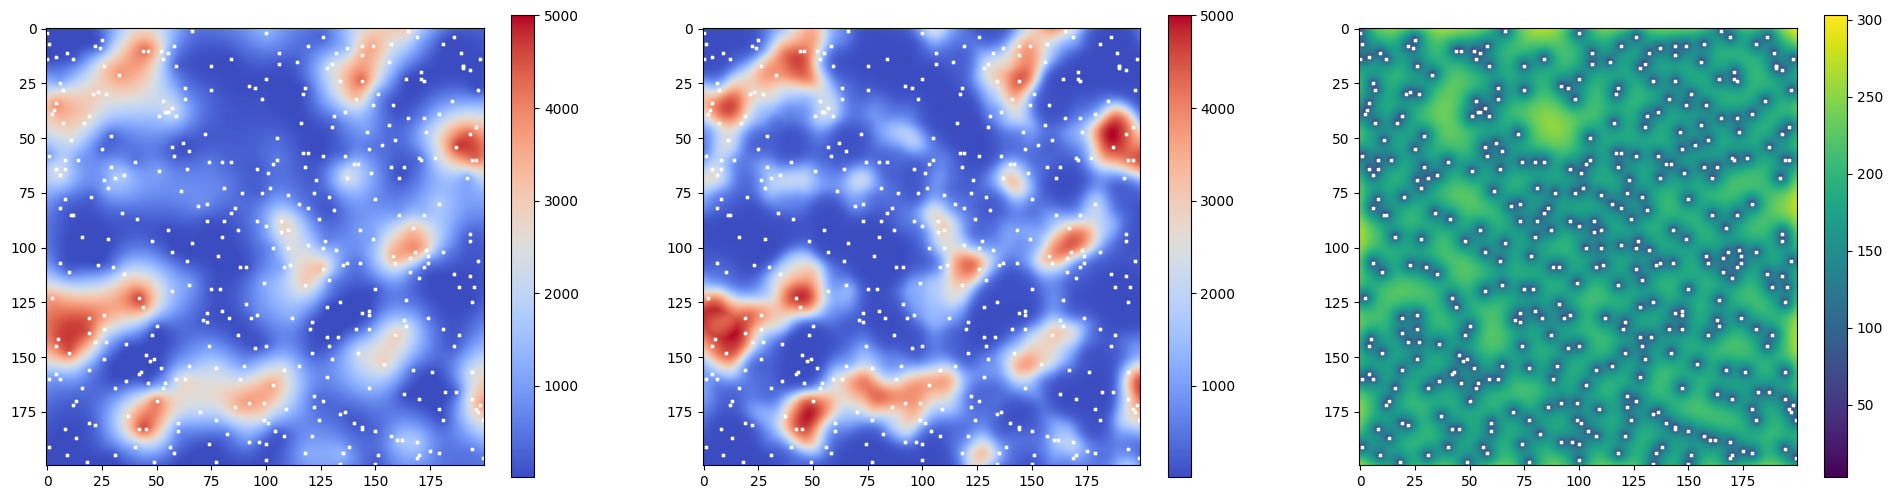

In [7]:
plt.figure(figsize=(24, 6))

cmap = "coolwarm"

plt.subplot(1, 3, 1)
plt.imshow(mean, cmap=cmap, vmin=10, vmax=5000)
plt.colorbar()
plt.scatter(X[:, 1], X[:, 0], s=4, c="white", marker="x")

plt.subplot(1, 3, 2)
plt.imshow(true_bedrock, cmap=cmap, vmin=10, vmax=5000)
plt.colorbar()
plt.scatter(X[:, 1], X[:, 0], s=4, c="white", marker="x")

plt.subplot(1, 3, 3)
plt.imshow(var ** 0.5)
plt.colorbar()
plt.scatter(X[:, 1], X[:, 0], s=4, c="white", marker="x")

plt.show()

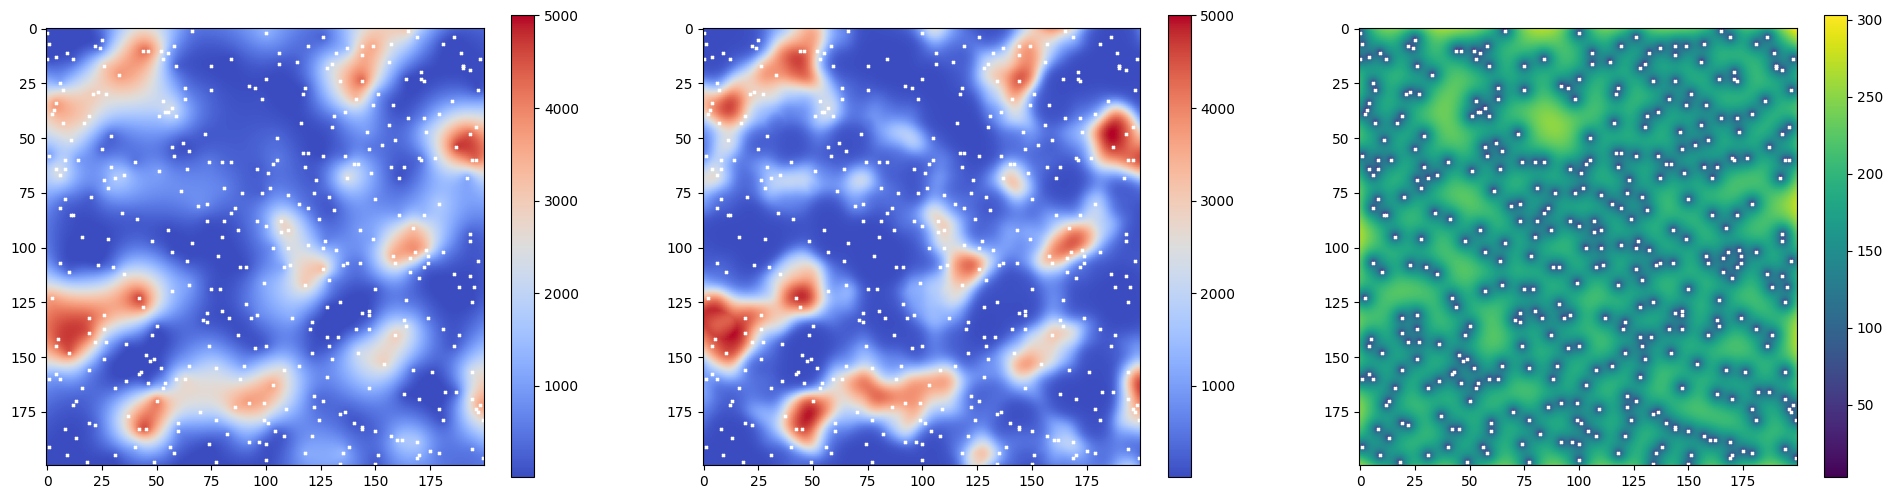

In [8]:
plt.figure(figsize=(24, 6))

cmap = "coolwarm"

plt.subplot(1, 3, 1)
plt.imshow(mean2, cmap=cmap, vmin=10, vmax=5000)
plt.colorbar()
plt.scatter(X[:, 1], X[:, 0], s=4, c="white", marker="x")

plt.subplot(1, 3, 2)
plt.imshow(true_bedrock, cmap=cmap, vmin=10, vmax=5000)
plt.colorbar()
plt.scatter(X[:, 1], X[:, 0], s=4, c="white", marker="x")

plt.subplot(1, 3, 3)
plt.imshow(var2 ** 0.5)
plt.colorbar()
plt.scatter(X[:, 1], X[:, 0], s=4, c="white", marker="x")

plt.show()

In [9]:
import random
edges = []
for y in range(5):
    for x in range(4):
        edges.append((y * 5 + x, y * 5 + x + 1, random.randint(1, 9) ** 2.))
        edges.append((x * 5 + y, (x + 1) * 5 + y, random.randint(1, 9) ** 2.))
G = [[] for _ in range(25)]
for a, b, c in edges:
    G[a].append([b, c])
    G[b].append([a, c])
R = [0, 4, 20, 24]

G_nx = nx.Graph([(a, b, {"weight": c}) for a, b, c in edges])

G, R


([[[1, 16.0], [5, 36.0]],
  [[0, 16.0], [2, 81.0], [6, 81.0]],
  [[1, 81.0], [3, 1.0], [7, 4.0]],
  [[2, 1.0], [4, 36.0], [8, 16.0]],
  [[3, 36.0], [9, 16.0]],
  [[0, 36.0], [10, 16.0], [6, 9.0]],
  [[5, 9.0], [1, 81.0], [7, 9.0], [11, 36.0]],
  [[6, 9.0], [8, 64.0], [2, 4.0], [12, 36.0]],
  [[7, 64.0], [9, 49.0], [3, 16.0], [13, 16.0]],
  [[8, 49.0], [4, 16.0], [14, 64.0]],
  [[5, 16.0], [15, 9.0], [11, 4.0]],
  [[6, 36.0], [16, 4.0], [10, 4.0], [12, 64.0]],
  [[11, 64.0], [7, 36.0], [13, 4.0], [17, 49.0]],
  [[12, 4.0], [14, 36.0], [8, 16.0], [18, 25.0]],
  [[13, 36.0], [9, 64.0], [19, 9.0]],
  [[10, 9.0], [20, 25.0], [16, 4.0]],
  [[11, 4.0], [21, 64.0], [15, 4.0], [17, 1.0]],
  [[12, 49.0], [22, 16.0], [16, 1.0], [18, 16.0]],
  [[17, 16.0], [13, 25.0], [19, 1.0], [23, 36.0]],
  [[18, 1.0], [14, 9.0], [24, 81.0]],
  [[15, 25.0], [21, 36.0]],
  [[16, 64.0], [20, 36.0], [22, 16.0]],
  [[17, 16.0], [21, 16.0], [23, 81.0]],
  [[18, 36.0], [22, 81.0], [24, 36.0]],
  [[23, 36.0], [19, 81.

238.0


/var/folders/yl/c0skfp955y50ml5hkymrf1ldtdh369/T/ipykernel_19330/1846187699.py:4: FutureWarning: steiner_tree will change default method from 'kou' to 'mehlhorn'in version 3.2.
Set the `method` kwarg to remove this warning.
  G_steiner_nx = nx_steiner_tree(G_nx, R)


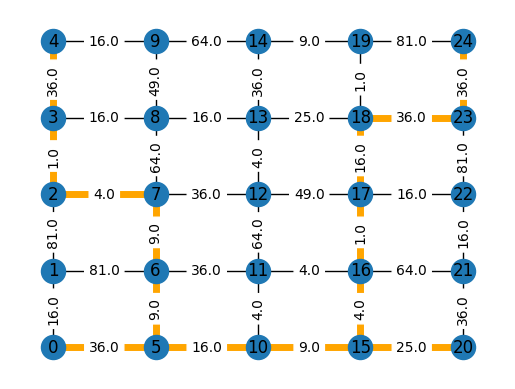

In [10]:
# 参考: https://scmopt.github.io/opt100/08steiner.html

from networkx.algorithms.approximation.steinertree import steiner_tree as nx_steiner_tree
G_steiner_nx = nx_steiner_tree(G_nx, R)

cost = 0
for v, u in G_steiner_nx.edges():
    cost += G_nx[v][u]["weight"]
print(cost)
pos = {y * 5 + x: (y, x) for y in range(5) for x in range(5)}
edge_labels = {(v, u): str(G_nx[v][u]["weight"]) for v, u in G_nx.edges()}
nx.draw_networkx(G_nx, pos)
nx.draw(G_nx, pos, width=5, edgelist=G_steiner_nx.edges(), edge_color="orange", node_size=0)
nx.draw_networkx_edge_labels(G_nx, pos, edge_labels=edge_labels)
plt.show()


In [11]:
from steiner import solve_steiner
res = solve_steiner(G, R)

237.0


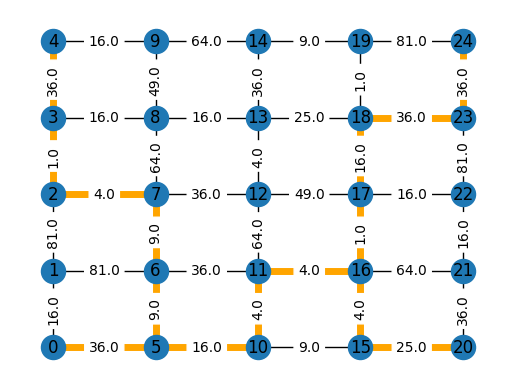

In [12]:
cost2 = 0
for v, u in res:
    cost2 += G_nx[v][u]["weight"]
print(cost2)

nx.draw_networkx(G_nx, pos)
nx.draw(G_nx, pos, width=5, edgelist=res, edge_color="orange", node_size=0)
nx.draw_networkx_edge_labels(G_nx, pos, edge_labels=edge_labels)
plt.show()